## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("../../data/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [17]:
test=np.genfromtxt("../../data/Index2018.csv", delimiter=",", skip_header=True)

In [19]:
X1 = test[:,0:3]
Y1 = test[:,4]

X1

array([[         nan,   469.9     ,  2224.95    ],
       [         nan,   475.27    ,  2225.      ],
       [         nan,   474.13    ,  2228.1     ],
       ...,
       [         nan,  2839.253031, 13298.36    ],
       [         nan,  2872.867839, 13340.17    ],
       [         nan,  2853.528411, 13324.48    ]])

In [16]:
print(raw_csv_data.to_numpy())

[['07/01/1994' 469.9 2224.95 3445.98 18124.01]
 ['10/01/1994' 475.27 2225.0 3440.58 18443.44]
 ['11/01/1994' 474.13 2228.1 3413.77 18485.25]
 ...
 ['25/01/2018' 2839.2530309999997 13298.36 7615.839954000001 23669.49]
 ['26/01/2018' 2872.867839 13340.17 7665.541292 23631.88]
 ['29/01/2018' 2853.528411 13324.48 7671.5333 23629.34]]


In [18]:
df_comp['market_value']=df_comp.ftse

In [19]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [20]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [21]:
import warnings
warnings.filterwarnings("ignore")

## Creating Returns

In [22]:
#help(df.market_value.pct_change(1))
s = pd.Series([90, 91, 90,91,34,32,88,85])
s.pct_change(periods=1)

0         NaN
1    0.011111
2   -0.010989
3    0.011111
4   -0.626374
5   -0.058824
6    1.750000
7   -0.034091
dtype: float64

In [23]:
df['returns'] = df.market_value.pct_change(periods=1)*100

## ACF for Returns
 how many lags we should to use for model 

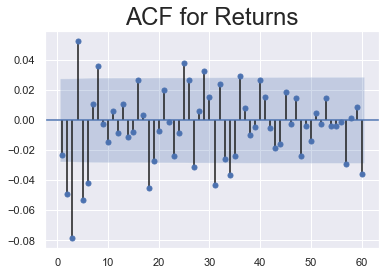

In [24]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 60)
plt.title("ACF for Returns", size=24)
plt.show()

## MA(1) for Returns

order(P,Q) :: P shows the AR model ,and will ask model to get the AR for P lag , like (6,0) AR model for 6th lag. 
however, Q is MA componenet . if we have whitenose , or non, stationary , we may need to work with MA model instead. 
in this senario, we ar going to just work with MA model. 
So order would be (P=0,Q=1) , means , MA for the first lag 

In [25]:
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sun, 10 Jan 2021   AIC                          15865.190
Time:                        19:04:50   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""

as we can see, the P-Value for the first lag is not very significant. We expect is based on the ACF report. but let's try next 6 lag as they are all out of the blue box

<img src="MA_ACF.jpg"></img>



## Higher-Lag MA Models for Returns

In [26]:
model_ret_ma_2 = ARMA(df.returns[1:], order=(0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Sun, 10 Jan 2021   AIC                          15853.728
Time:                        19:04:50   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     

In [27]:
model_ret_ma_3 = ARMA(df.returns[1:], order=(0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Sun, 10 Jan 2021   AIC                          15818.634
Time:                        19:04:50   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     

In [28]:
model_ret_ma_4 = ARMA(df.returns[1:], order=[0,4])
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sun, 10 Jan 2021   AIC                          15809.547
Time:                        19:04:51   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     

In [29]:
model_ret_ma_5 = ARMA(df.returns[1:], order=[0,5])
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 5)   Log Likelihood               -7892.823
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sun, 10 Jan 2021   AIC                          15799.645
Time:                        19:04:52   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.851      0.064      -0.054       0.002
ma.L2.returns    -0.0497      0.014     

In [30]:
model_ret_ma_6 = ARMA(df.returns[1:], order=[0,6])
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sun, 10 Jan 2021   AIC                          15794.442
Time:                        19:04:55   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     

In [31]:
model_ret_ma_7 = ARMA(df.returns[1:], order=[0,7])
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sun, 10 Jan 2021   AIC                          15796.091
Time:                        19:04:59   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     

In [32]:
model_ret_ma_8 = ARMA(df.returns[1:], order=[0,8])
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sun, 10 Jan 2021   AIC                          15791.205
Time:                        19:05:05   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     

In [33]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF = 2)

0.027

## Residuals for Returns

In [36]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [40]:
#df.res_ret_ma_8.mean()

-2.216446175354222e-05

In [41]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))


The mean of the residuals is -0.0
The variance of the residuals is 1.356


In [43]:
df.res_ret_ma_8.describe()

count    5019.000000
mean       -0.000022
std         1.164267
min        -8.774206
25%        -0.555738
50%         0.034847
75%         0.601657
max         9.042022
Name: res_ret_ma_8, dtype: float64

In [44]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

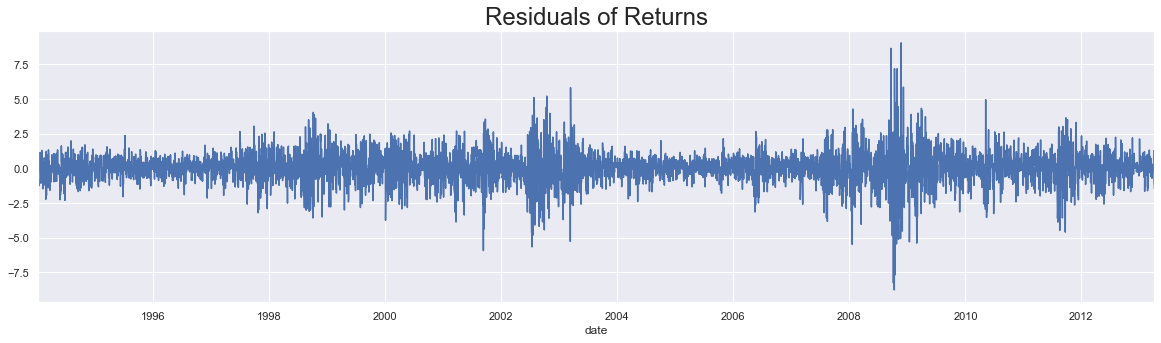

In [45]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [46]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83581917071635,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052184992737)

Pvalue is equal to 0 , then the data ( retuen data is indeed statunary !)

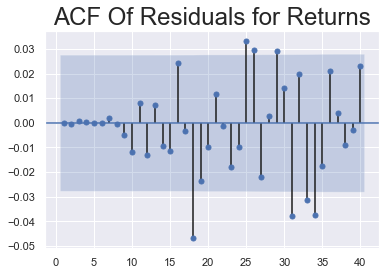

In [47]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Normalized Returns

In [54]:
#df['returns'] = df.market_value.pct_change(periods=1)*100
#df['norm_ret'] = df.returns.div(bench_ret).mul(100) :: (df.returns/bench_ret)*(100)
# df['norm_ret']=df.applay(lapbda x :df.returns/bench_ret)*(100))

bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

In [56]:
print(df.iloc[1])
print(bench_ret)
print(df['norm_ret'].describe())

market_value    3440.580000
returns           -0.156704
res_ret_ma_8            NaN
norm_ret         100.000000
Name: 1994-01-10 00:00:00, dtype: float64
-0.1567043337454055
count    5020.000000
mean      -11.973050
std       749.661653
min     -6278.557121
25%      -387.694338
50%        -3.627435
75%       346.868490
max      5647.115310
Name: norm_ret, dtype: float64


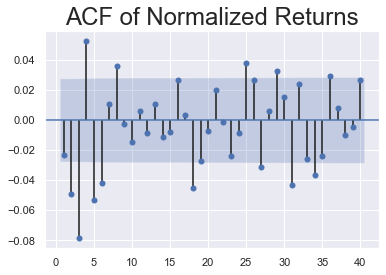

In [58]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

In [59]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Sun, 10 Jan 2021   AIC                          80635.194
Time:                        19:46:00   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.846     -1.354      0.176     -29.310       5.364
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [60]:
df['res_norm_ret_ma_8'] = results_ret_ma_8.resid[1:]

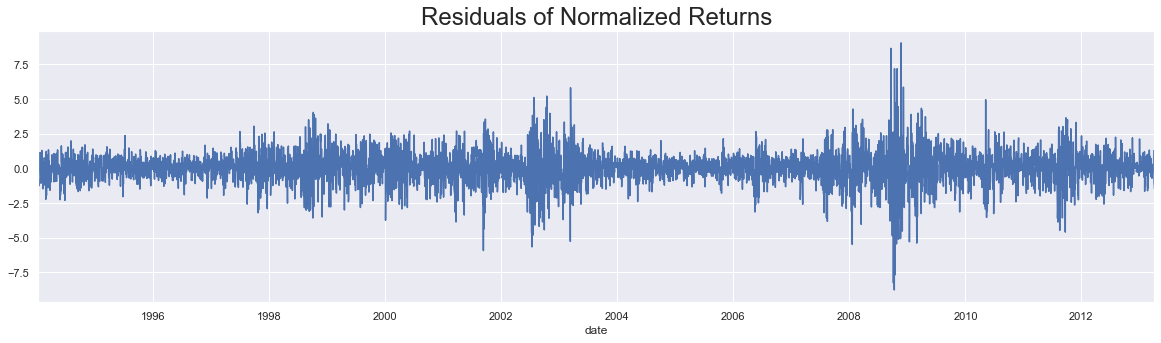

In [61]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

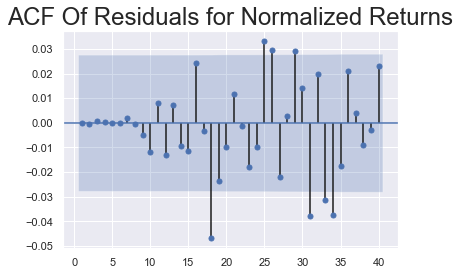

In [63]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

## MA Models For Prices

## AR model is less reliable when we are working on non stationary data ! 
Let's try the Market value data 

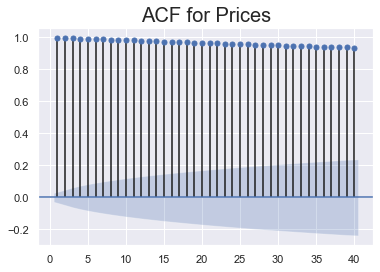

In [66]:
### how many lags should we consider to build the model ? it looks all the 40 past lage are significats ! it's because of our data is non stationary ! 

sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

based on this report, we need to use infinit MA model ( MA( alfa)) to build the efficient model ! but let's try some ARE model 


For these typoe of data, ( non stationary data , we can find auto corelation data as a trends. the erroro resio between each two lag would be close to 1 . 

stationary data will have beter performanace on AR model instead of MA one. 

In [79]:
model_ma_1 = ARMA(df.market_value, order=(0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Sun, 10 Jan 2021   AIC                          77264.000
Time:                        20:15:11   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6995     14.660    347.194      0.000    5060.967    5118.432
ma.L1.market_value     0.9573      0.003    335.556      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""

In [83]:
def MA_R_model(df,AR=0,Order=1):
    
    for i in range(1,Order):
        print(i)
    
        model_ma_1 = ARMA(df, order=(AR,i))
        results_ma_1 = model_ma_1.fit()
        results_ma_1.summary()
        print(results_ma_1.summary())
        

        """if i >=2:
            
        
            model_first = ARMA(df, order=(0,1))
            #results_first = model_first.fit()
            model_second = ARMA(df, order=(0,Order))
            #results_second = model_second.fit()


            print( "LLR report :", LLR_test(model_first, model_second, DF = i-1 ))
        """
    

In [81]:
MA_R_model(df.market_value,Order=20)

1
                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Sun, 10 Jan 2021   AIC                          77264.000
Time:                        20:15:41   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6995     14.660    347.194      0.000    5060.967    5118.432
ma.L1.market_value     0.9573      0.003    335.556      0.000       0.952       0.963
                  

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 6)   Log Likelihood              -31234.614
Method:                       css-mle   S.D. of innovations            121.662
Date:                Sun, 10 Jan 2021   AIC                          62485.228
Time:                        20:15:48   BIC                          62537.399
Sample:                    01-07-1994   HQIC                         62503.509
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.3131     20.835    244.262      0.000    5048.476    5130.150
ma.L1.market_value     1.9185      0.014    139.777      0.000       1.892       1.945
ma.L2.market_value  

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                    ARMA(0, 10)   Log Likelihood              -29753.604
Method:                       css-mle   S.D. of innovations             90.584
Date:                Sun, 10 Jan 2021   AIC                          59531.207
Time:                        20:16:21   BIC                          59609.464
Sample:                    01-07-1994   HQIC                         59558.629
                         - 04-05-2013                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5088.8779     26.276    193.669      0.000    5037.378    5140.378
ma.L1.market_value      1.6660      0.015    113.185      0.000       1.637       1.695
ma.L2.market_val

KeyboardInterrupt: 

In [84]:
MA_R_model(df.market_value,AR=7,Order=8)

1
                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 1)   Log Likelihood              -27591.805
Method:                       css-mle   S.D. of innovations             58.895
Date:                Sun, 10 Jan 2021   AIC                          55203.609
Time:                        20:17:26   BIC                          55268.823
Sample:                    01-07-1994   HQIC                         55226.461
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6428    587.247      8.667      0.000    3938.660    6240.626
ar.L1.market_value     0.8684      0.203      4.275      0.000       0.470       1.267
ar.L2.market_value

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 4)   Log Likelihood              -27590.960
Method:                       css-mle   S.D. of innovations             58.885
Date:                Sun, 10 Jan 2021   AIC                          55207.920
Time:                        20:17:53   BIC                          55292.698
Sample:                    01-07-1994   HQIC                         55237.627
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6688    578.574      8.797      0.000    3955.685    6223.653
ar.L1.market_value     0.4837      0.252      1.922      0.055      -0.010       0.977
ar.L2.market_value  

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 7)   Log Likelihood              -27585.965
Method:                       css-mle   S.D. of innovations             58.825
Date:                Sun, 10 Jan 2021   AIC                          55203.930
Time:                        20:19:49   BIC                          55308.272
Sample:                    01-07-1994   HQIC                         55240.492
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6553    581.482      8.753      0.000    3949.971    6229.339
ar.L1.market_value     0.8019      0.214      3.747      0.000       0.382       1.221
ar.L2.market_value  